In [1]:
#import os
#import sys
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt

from utils import plot_empirical_pdf, plot_empirical_cdf

# 1. Empirical Distribution Implementation

Empirical distribution is, in some sence, a sequence of discrete values. Hence, the cumulative distribution function (CDF) is represented by a step function. 
$$
    F_n(x) = P(X \le x) = \sum_i I[X_i \le x]
$$

<img src="images/cdf1.png" alt="CDF" width="500"  class="center">

Probability mass function(PMF) shows the frequences of values in the sample.

<img src="images/pdf_discrete.png" width="500"  class="center">

If the random variable in question is continuous, and we can talk about its probability density function (if it exists). 

<img src="images/pdf_continuous.png" width="500"  class="center">

We will represent PDF as sum of kernel functions at the sample points. Hence, for intervals with higher point density there will be higher probability density than for parts with fewer points.

Let's implement simple empirical distribution class. 

In [2]:
class EmpiricalDistribution:
    """
    This class provides empirical distribution functionality. It can be used to 
    get point masses and cdf arrays for plotting.
    
    This implementations assumes that
    F(x) = P(X <= x) = Sum_i I[X_i <= x]
    """
    def __init__(self, samples):
        """
        Initialize empirical distribution.
        
        Arguments:
        - samples: numpy array, list or tuple of 1D samples
        """
        self.samples = np.sort(samples)
        
    def get_pdf_data(self):
        """
        Get data required to plot PDF. 
        """
        points, counts = np.unique(self.samples, return_counts=True)
        density = counts / counts.sum()
        return points, density
    
    def get_continuous_pdf_data_(self, n_points=10, covariance_factor=None):
        """
        Get data required to plot PDF. 
        """
        points, weights = self.get_pdf_data()
        density = stats.gaussian_kde(points, weights=weights)
        if covariance_factor is not None:
            density.covariance_factor = lambda : covariance_factor
            density._compute_covariance()
        
        xs = np.linspace(points[0], points[-1], n_points)
        return xs, density(xs)
    
    def get_cdf_data(self, append_borders=1e-3):
        """
        Get data required to plot CDF.
        
        Arguments:
        - append_borders: nonegative number. 
            If append_borders > 0, adds border points x_left and x_right such that F(x_left) = 0, F(x_right) = 1.
            It is required for appropriate plotting since otherwise the plots do not show levels 0 and 1 of CDF. 
            The values of x_left and x_right are found as follows:
                x_left = min(samples) - append_borders * (max(samples) - min(samples))
                x_right = max(samples) +  append_borders * (max(samples) - min(samples))
            
        Returns shape (points, cumulatives):
        - points: numpy array which contains stored samples (and border points if append_borders > 0) 
            in ascending order.
        - cumulatives: numpy array which contains CDF values for the returned points. 

        """
        
        points, densities = self.get_pdf_data()
        cumulatives = np.cumsum(densities)

        x_delta = points[-1] - points[0]
        x_left = points[0] - append_borders * x_delta
        x_right = points[-1] +  append_borders * x_delta

        return np.r_[x_left, points, x_right], np.r_[0, cumulatives, 1]


# 2. Empirical distribution function

Now, we can look at empirical CDF and PDF for some discrete and continouos probability distributions. In this part we will actively use [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) library. 

In [3]:
from scipy.stats import binom, poisson, norm, chi2, t, triang

## 2.1 Discrete distributions

In [4]:
def plot_discrite_distribution(gen, size):
    
    samples = gen.rvs(size=size, random_state=7)

    edist = EmpiricalDistribution(samples)

    figsize = (14, 6)
    f, axarr = plt.subplots(1, 2, figsize=figsize)

    points, cumulatives = edist.get_cdf_data(append_borders=0.1)
    plot_empirical_cdf(points, cumulatives, axarr[0], gen=gen, xlabel='$x$', ylabel='$F(x)$', title='CDF')

    points, masses = edist.get_pdf_data()
    plot_empirical_pdf(points, masses, axarr[1], gen_pdf=gen.pmf, xlabel='$x$', ylabel='$p(x)$', title='PMF', 
                       arrowwidth=None, headwidth=3, headlength=4)

### 2.1.1 Binomial distribution

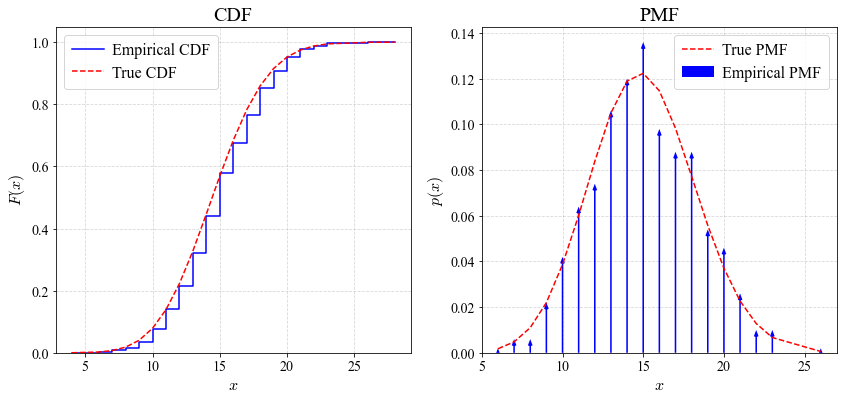

In [5]:
gen = binom(n=50, p=0.3)
plot_discrite_distribution(gen, 500)

### 2.1.2 Poisson distriburion

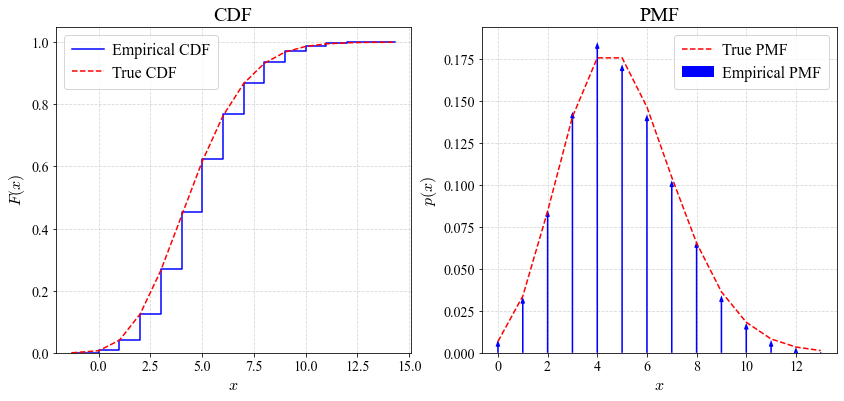

In [6]:
gen = poisson(mu=5)
plot_discrite_distribution(gen, size=5000)

## 2.2 Continuous distributions

For continouos distributions plot also CDF and PDF of original(true) distribution to compare with empirical one.

In [7]:
def plot_continuous_distribution(gen, size, covariance_factor=None):

    samples = gen.rvs(size=size, random_state=6)
    edist = EmpiricalDistribution(samples)

    figsize = (14, 6)
    f, axarr = plt.subplots(1, 2, figsize=figsize)

    points, cumulatives = edist.get_cdf_data(append_borders=0.01)
    plot_empirical_cdf(points, cumulatives, axarr[0], xlabel='$x$', ylabel='$F(x)$', title='CDF', 
                       gen=gen, gen_color="r--")

    points, masses = edist.get_continuous_pdf_data_(n_points=50, covariance_factor=covariance_factor)
    plot_empirical_pdf(points, masses, axarr[1], xlabel='$x$', ylabel='$p(x)$', title='PDF', 
                       arrowwidth=None, headwidth=3, headlength=4, color='b', gen_pdf=gen.pdf, gen_color="r")    

### 2.2.1 Normal distribution

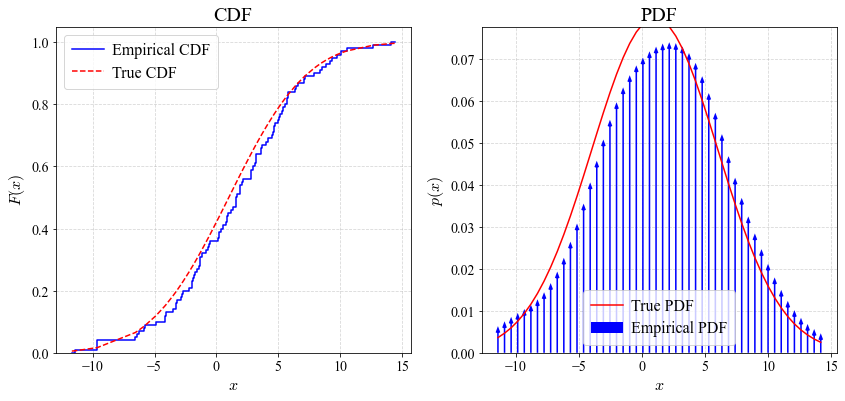

In [8]:
gen = norm(loc=1, scale=5)
plot_continuous_distribution(gen, size=100)

### 2.2.2 $\chi^2$ distribution

Pronounced "chi-squared".

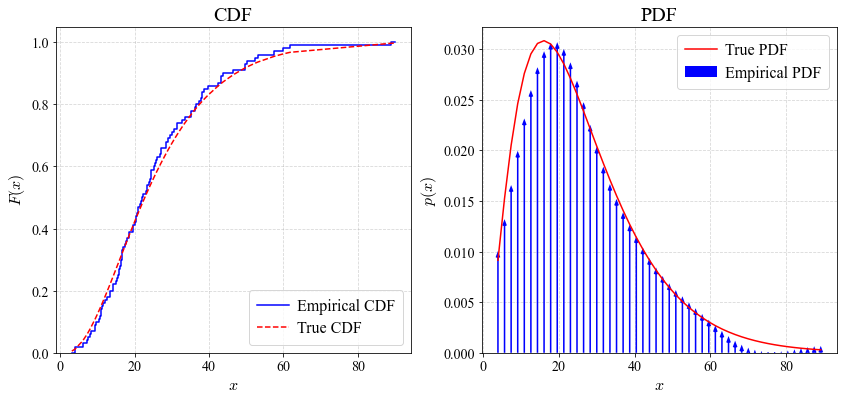

In [9]:
gen = chi2(df=5, loc=1, scale=5)
plot_continuous_distribution(gen, size=100)

### 2.2.3 Student distribution

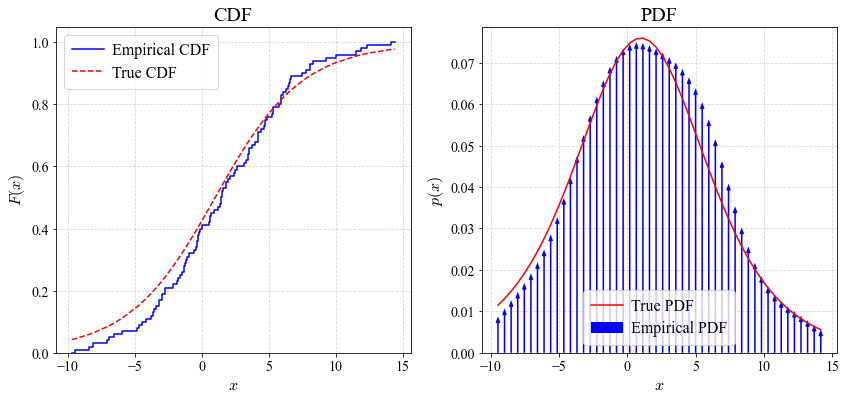

In [10]:
gen = t(df=5, loc=1, scale=5)
plot_continuous_distribution(gen, 100)

### 2.2.4 Triangular distribution

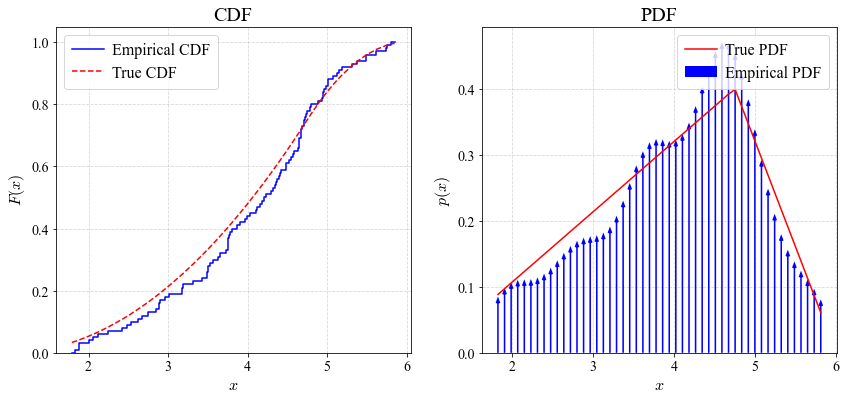

In [11]:
gen = triang(c=0.75, loc=1, scale=5)
plot_continuous_distribution(gen, size=100, covariance_factor=0.25)

# 3. Empirical Functions Estimation and Confidence Intervals

Confidence Interval (CI) is a type of estimate computed based on observed data. It proposes a range of plausible values for an unknown fixed parameter (for example, the mean). The interval has an associated confidence level $\gamma$ that the true parameter is in the proposed range. Given observations $x_1, \dots, x_n$  and a confidence level $\gamma$, probability $\gamma$ relates to the reliability of the estimation procedure.

## 3.1 Naive approach

Let's estimate confidence set for mean and variance based on simulation. Get samples from distribution and estimate target(mean or variance). Repeat many times.

In [12]:
from scipy.stats import norm

In [13]:
def get_confidence_interval(func, gen, size=1000, n_repeats=1000, alpha=0.05):
    
    repeats = np.empty(n_repeats)

    for i in range(n_repeats): 
        samples = gen.rvs(size=size)
        repeats[i] = func(samples)
    
    conf_interval = np.quantile(repeats, (alpha/2, 1-alpha/2))
    name = func.__name__.split(".")[-1]
    print(f"{name}: estimation {np.mean(repeats):.3f} with 95% confidence interval ({conf_interval[0]:.3f}, {conf_interval[1]:.3f})")

In [14]:
gen = norm(loc=4, scale=2)
get_confidence_interval(np.mean, gen)

mean: estimation 4.002 with 95% confidence interval (3.879, 4.122)


In [15]:
gen = norm(loc=2, scale=5)
get_confidence_interval(np.var, gen)

var: estimation 24.971 with 95% confidence interval (22.999, 27.351)


## 3.2 Confidence Set for CDF from DKW inequality

To estimate CDF $F(x)$ from empirival CDF $F_n(x)$ we can use DKW inequality (Dvoretzky–Kiefer–Wolfowitz):
$$
    F_n(x)-\epsilon \le F(x) \le F_n(x)+\epsilon,~~~\epsilon = \sqrt{\frac1{2n}\log\big(\frac2\alpha\big)}
$$

In [16]:
def plot_confidence_set(samples, ax, alpha=0.05):
    
    edist = EmpiricalDistribution(samples)

    points, cumulatives = edist.get_cdf_data(append_borders=0.1)
    eps = np.sqrt(0.5 / len(edist.samples) * np.log(2/alpha))
    lower_bounds = np.max((cumulatives-eps, ), axis=0, initial=0)
    upper_bounds = np.min((cumulatives+eps, ), axis=0, initial=1)
    
    ax.plot(points, cumulatives, "r-", label="CDF")
    ax.plot(points, lower_bounds, "k--", label="Lower bound")
    ax.plot(points, upper_bounds, "k-.", label="Upper bound")
    ax.legend()
    ax.grid(True)
    ax.set_ylabel("$F(x)$")
    ax.set_xlabel("$x$")

Let's estimate $F(x)$ and its confidence set for samples of different size.

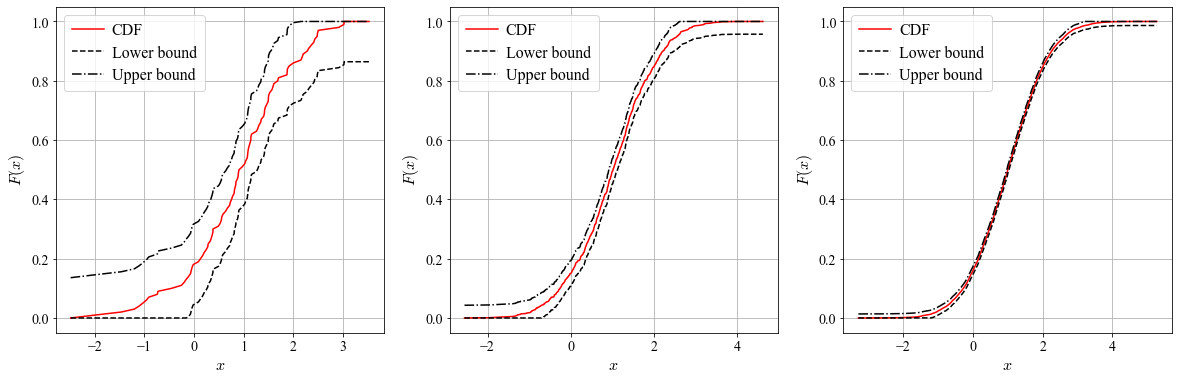

In [17]:
gen = norm(loc=1, scale=1)

sizes = np.logspace(2, 4, 3).astype(int) #100, 1000, 10000
fig, axarr = plt.subplots(ncols=3, figsize=(20, 6))

for size, ax in zip(sizes, axarr):
    samples = gen.rvs(size=size)
    plot_confidence_set(samples, ax)

# 4. Kullback-Leibler Distance/Divirgence

In [18]:
import numpy as np
from scipy.stats import uniform, entropy, multivariate_normal, binom

To measure the distance between two distributions we can use KL distance:
$$
    D_{KL}\big(f(x), g(x)\big) = \int_{-\infty}^{\infty} f(x)~\log\left(\frac{f(x)}{g(x)}\right) dx
$$


## 4.1 Two uniform distributions. 

Firstly estimate KL distance between two uniform distributions with the same parameters and then between two uniform distributions with different parameters.

In [19]:
def plot_two_uniform(points, rv1, rv2):
    plt.figure(figsize=(7, 6))
    plt.plot(points, rv1.pdf(points), "r", label="Uniform(1, 6)")
    plt.plot(points, rv2.pdf(points), "b", label="Uniform(1, 4)")
    plt.xlabel("$x$")
    plt.ylabel("$p(x)$")
    plt.legend()


'Distance between 2 uniform distributions with the same parameters 0.000 and with different parameters 0.498'

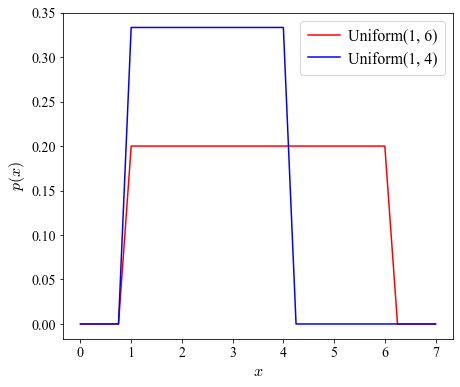

In [20]:
pos = np.linspace(1, 6, 51)
pos_with_bounds = np.linspace(0, 7, 29)
rv1 = uniform(loc=1, scale=5)  # Uniform(1,6)
rv2 = uniform(loc=1, scale=3)  # Uniform(1,4)

plot_two_uniform(pos_with_bounds, rv1, rv2)

kl_dist_same = entropy(rv1.pdf(pos), rv1.pdf(pos))
kl_dist_diff = entropy(rv2.pdf(pos), rv1.pdf(pos))

f"Distance between 2 uniform distributions with the same parameters {kl_dist_same:.3f} and with different parameters {kl_dist_diff:.3f}"

## 4.2 Two multivariate normal distributions.


We can estimate KL distance theoretiacally for two multivariate normal distributions. For a simple case, when one of them has diagonal covariance matrix ($\Sigma= diag(\sigma_1, \dots, \sigma_k)$) and another one is standard normal distribution, get

$$
    D_{KL}\big(N(\mu, \Sigma)||N(0, I)\big) = \frac12 \sum_i^k \big(\sigma_i^2 + \mu_i^2 - 1 -\log(\sigma_i^2)\big)
$$

Let's check it.

In [21]:
def kl_distance_simple_case(mu, sigma):
    """Estimate theoratical KL distance for simple case"""
    return 0.5 * np.sum(sigma**2 + mu**2 - 1 - np.log(sigma**2))

def plot_2D_normal_distribution(pos, rv, ax):
    """Plot 2D normal distribution"""
    
    img = ax.contourf(pos[:, :, 0], pos[:, :, 1], rv.pdf(pos), cmap="RdBu_r")
    plt.colorbar(img, ax=ax)

Create point grid

In [22]:
step = .01
border = 2

x, y = np.mgrid[-border:border:step, -border:border:step]
pos = np.dstack((x, y))

Plot some 2D normal distribution.

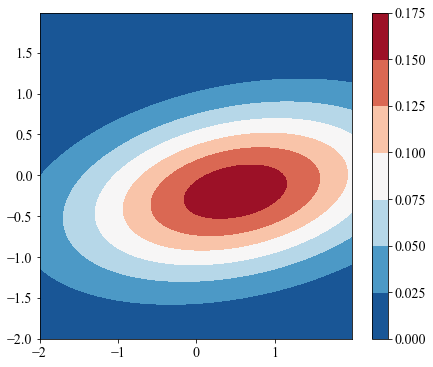

In [23]:
rv = scipy.stats.multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])

plt.figure(figsize = (7, 6))
ax = plt.subplot(111)
plot_2D_normal_distribution(pos, rv, ax)

Estimate distance between two normal distributions with the same parameters

'KL distance: exact 0.000, approximate 0.000'

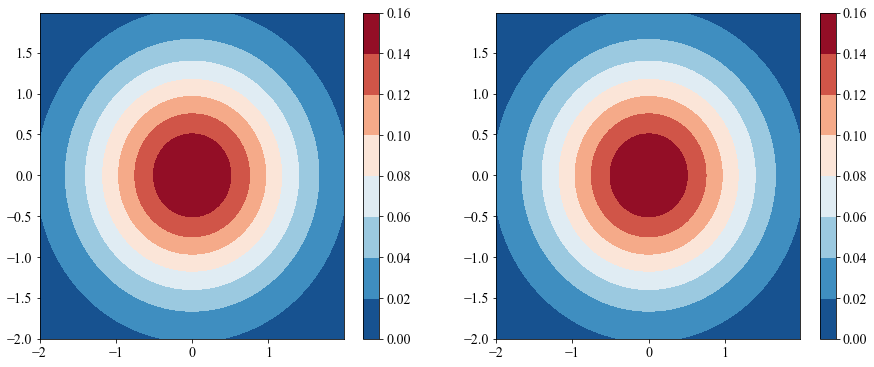

In [24]:
mean = np.zeros(2)
sigma = np.array([1, 1])

rv1 = scipy.stats.multivariate_normal(mean, np.diag(sigma))
rv2 = scipy.stats.multivariate_normal(np.zeros(2), np.eye(2))

figsize = (15, 6)
f, axarr = plt.subplots(1, 2, figsize=figsize)
plot_2D_normal_distribution(pos, rv1, axarr[0])
plot_2D_normal_distribution(pos, rv2, axarr[1])

kl_dist_theory = kl_distance_simple_case(mean, sigma)
kl_dist_practice = entropy(rv1.pdf(pos), rv2.pdf(pos)).sum()
f"KL distance: exact {kl_dist_theory:.3f}, approximate {kl_dist_practice:.3f}"

Estimate distance between 2 normal distributions with different parameters

'KL distance: exact 2.125, approximate 0.023'

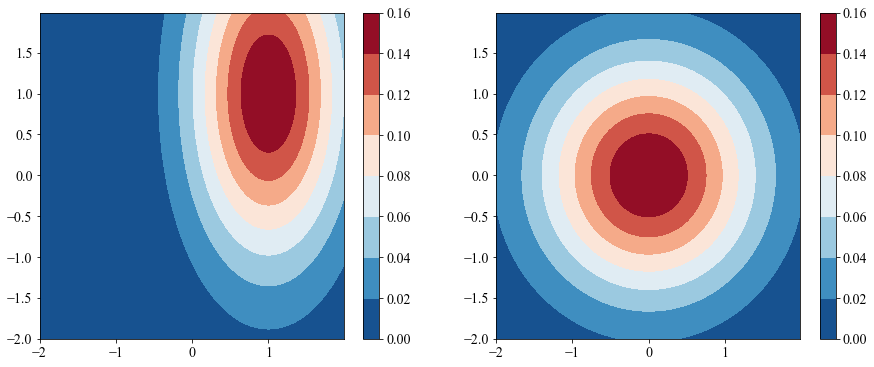

In [25]:
mean = np.ones(2)
sigma = np.array([0.5, 2])

rv1 = scipy.stats.multivariate_normal(mean, np.diag(sigma))
rv2 = scipy.stats.multivariate_normal(np.zeros(2), np.eye(2))

figsize = (15, 6)
f, axarr = plt.subplots(1, 2, figsize=figsize)
plot_2D_normal_distribution(pos, rv1, axarr[0])
plot_2D_normal_distribution(pos, rv2, axarr[1])

kl_dist_theory = kl_distance_simple_case(mean, sigma)
kl_dist_practice = entropy(rv1.pdf(pos), rv2.pdf(pos)).sum() * step**2
f"KL distance: exact {kl_dist_theory:.3f}, approximate {kl_dist_practice:.3f}"

Results are different as we do not cover the whole space but just a square of some size. In addition, it may be necessary to normalize integral by some constant.

## 4.3 Distance between original and empirical distributions.

Estimate distance between true and emperical distributions. Example: binomial distribution.

'Distance between true and empirical distributions 0.006'

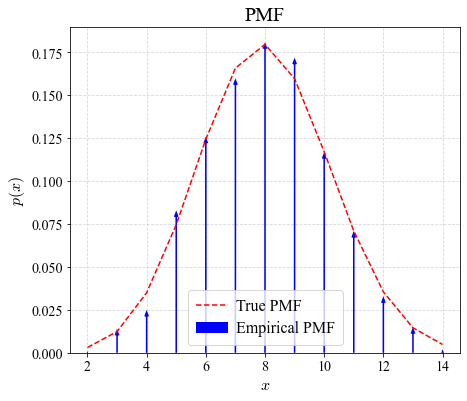

In [31]:
size = 1000
rv_original = binom(n=20, p=0.4)
rv_empirical = EmpiricalDistribution(rv_original.rvs(size=size))
points, probabilities = rv_empirical.get_pdf_data()

plt.figure(figsize=(7, 6))
ax = plt.subplot(111)
plot_empirical_pdf(points, probabilities, ax, xlabel='$x$', ylabel='$p(x)$', title='PMF', arrowwidth=None, headwidth=3, headlength=4, color='b', gen_pdf=rv_original.pmf)

kl_dist = entropy(rv_original.pmf(points), probabilities)


f"Distance between true and empirical distributions {kl_dist:.3f}"